## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt')]

In [4]:
#create path variables for labels and images
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_01680.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06630.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_009120.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009720_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f03930_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01110_P.png')]

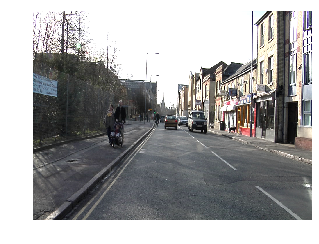

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [10]:
img_f

PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_01680.png')

In [11]:
img_f.stem

'0016E5_01680'

In [12]:
dir(img_f)

['__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__fspath__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__truediv__',
 '_accessor',
 '_cached_cparts',
 '_closed',
 '_cparts',
 '_drv',
 '_flavour',
 '_format_parsed_parts',
 '_from_parsed_parts',
 '_from_parts',
 '_hash',
 '_init',
 '_make_child',
 '_make_child_relpath',
 '_opener',
 '_parse_args',
 '_parts',
 '_pparts',
 '_raise_closed',
 '_raw_open',
 '_root',
 '_str',
 'absolute',
 'anchor',
 'as_posix',
 'as_uri',
 'chmod',
 'cwd',
 'drive',
 'exists',
 'expanduser',
 'glob',
 'group',
 'home',
 'is_absolute',
 'is_block_device',
 'is_char_device',
 'is_dir',
 'is_fifo',
 'is_file',
 'is_mount',
 'is_reserved',
 '

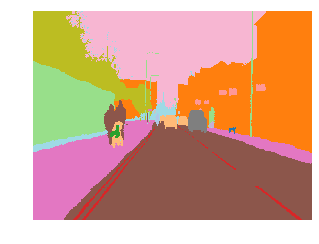

In [17]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [18]:
type(mask)

fastai.vision.image.ImageSegment

In [19]:
mask.shape

torch.Size([1, 720, 960])

In [20]:
img.shape

torch.Size([3, 720, 960])

In [24]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [21]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [22]:
type(codes)

numpy.ndarray

In [33]:
len(codes)

32

In [40]:
if 'Void' in codes: print(True)
else: print(False)

True


## Datasets

In [25]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [30]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [27]:
type(src)

fastai.data_block.LabelLists

In [28]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [29]:
type(data)

fastai.vision.data.ImageDataBunch

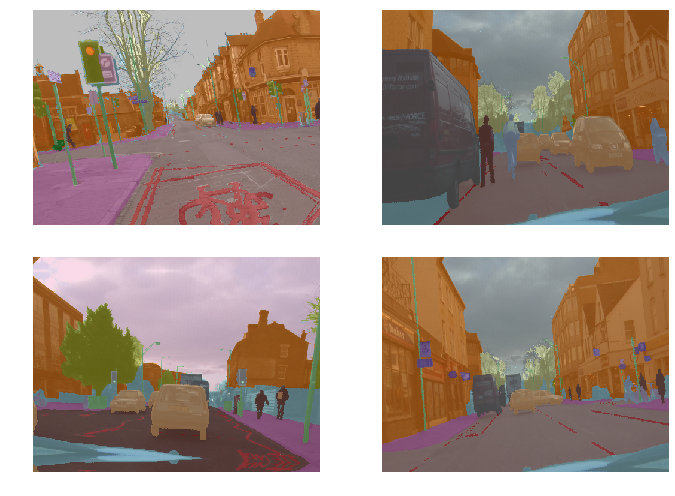

In [31]:
data.show_batch(2, figsize=(10,7))

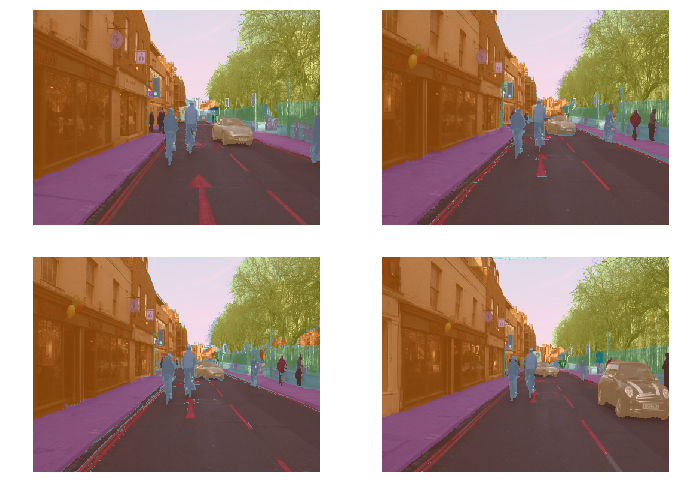

In [32]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [41]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void'] #extract void code

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [42]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [43]:
metrics=acc_camvid
# metrics=accuracy

In [44]:
wd=1e-2

In [45]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


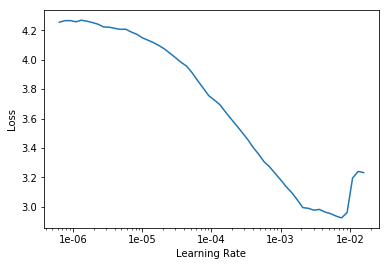

In [46]:
lr_find(learn)
learn.recorder.plot()

In [47]:
lr=1e-3

In [48]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.142435,0.858189,0.813102,01:42
1,0.739014,0.545899,0.846308,01:41
2,0.660877,0.588288,0.853319,01:41
3,0.594516,0.437322,0.870705,01:41
4,0.583010,0.455063,0.877421,01:41
5,0.554454,0.373336,0.898929,01:41
6,0.515068,0.412868,0.888986,01:40
7,0.503392,0.358220,0.898691,01:39
8,0.466228,0.369429,0.893617,01:39
9,0.386071,0.300312,0.913634,01:39


In [49]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

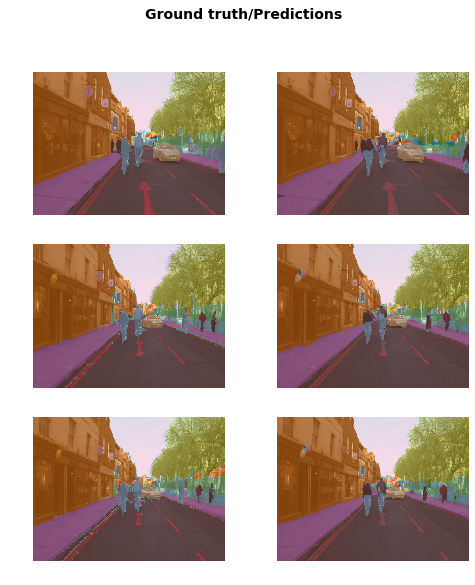

In [50]:
learn.show_results(rows=3, figsize=(8,9))

In [51]:
learn.unfreeze()

In [52]:
lrs = slice(lr/400,lr/4)

In [53]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.347581,0.291620,0.916144,01:42
1,0.350219,0.281772,0.920832,01:44
2,0.329080,0.284232,0.920545,01:45
3,0.332224,0.279963,0.923234,01:45
4,0.328102,0.282216,0.922806,01:44
5,0.313223,0.272109,0.921439,01:45
6,0.308478,0.280999,0.920162,01:45
7,0.301678,0.290503,0.914749,01:45
8,0.284642,0.268448,0.925222,01:45
9,0.284978,0.260279,0.931236,01:45


In [54]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [55]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7116MB of GPU RAM free


In [56]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [57]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


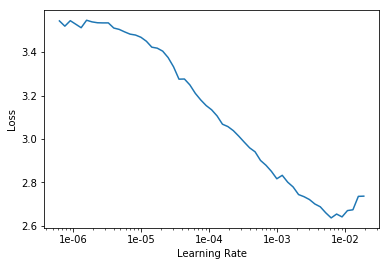

In [58]:
lr_find(learn)
learn.recorder.plot()

In [63]:
lr=1e-3

In [61]:
len(data.train_ds)

600

In [62]:
len(data.valid_ds)

101

In [64]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.801122,0.659407,0.841548,07:05
1,0.659085,0.571722,0.846961,07:06
2,0.690025,0.577619,0.859827,07:01
3,0.578975,0.456036,0.872330,06:55
4,0.591623,0.508813,0.869710,06:53
5,0.571602,0.479368,0.879925,06:52
6,0.465873,0.371423,0.903829,06:52
7,0.449429,0.354925,0.903455,06:51
8,0.349333,0.313154,0.919440,06:51
9,0.319304,0.276098,0.920222,06:51


In [65]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [66]:
learn.unfreeze()

In [67]:
lrs = slice(1e-6,lr/10)

In [68]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.290243,0.290531,0.916606,07:11
1,0.289673,0.278942,0.919917,07:14
2,0.252615,0.276386,0.919658,07:14
3,0.296501,0.292064,0.916278,07:14
4,0.256751,0.279932,0.921250,07:15
5,0.232047,0.263119,0.926454,07:14
6,0.244405,0.276241,0.922171,07:14
7,0.239398,0.264245,0.925486,07:14
8,0.213969,0.282921,0.920678,07:15
9,0.203253,0.279461,0.921964,07:14


In [69]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

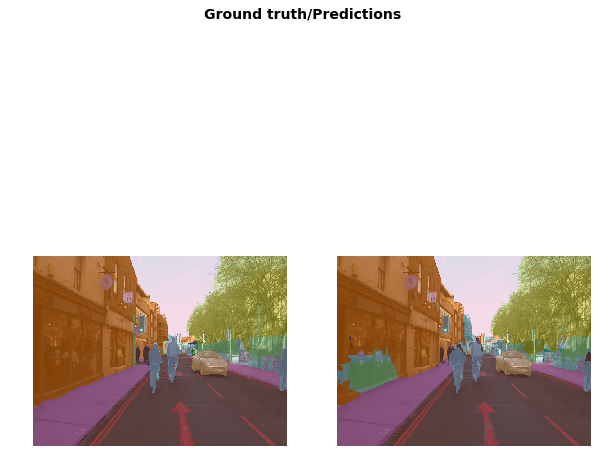

In [72]:
learn.show_results(rows=4, figsize=(10,10))

## fin